In [1]:
import numpy as np
import numba
from numba.types import *
from numba import prange
import matplotlib.pyplot as plt
from numpy.linalg import eig, multi_dot, inv, matrix_power, eigh
from scipy.optimize import curve_fit
from matplotlib import rcParams, cm
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.size']=20
from scipy.linalg import expm, sqrtm
from scipy.stats import linregress
from math import acos, factorial
from scipy.special import eval_genlaguerre, gamma, hyp1f1

In [2]:
#N=10 #Dimension of the Hilbert Space
#S=5
dim=20
A=1 #Probability distribution will be P~exp(-A x^2)
sigma=np.sqrt(A/2)
#t_max=0.5
#n_points_t=50
#t_arr=np.linspace(0, t_max, n_points_t)
basis = np.identity(dim)
i=complex(0,1)
beta_max=2
beta_min=1e-3
nbeta=40
beta_Logscale=True
if beta_Logscale:
    aux_betamin=np.log10(beta_min)
    aux_betamax=np.log10(beta_max)
    auxbeta=np.linspace(aux_betamin, aux_betamax, nbeta)
    beta_arr=10**auxbeta
else:
    beta_arr=np.linspace(beta_min, beta_max, nbeta)
#beta_arr=np.asarray([0.1, 0.5, 1, 2])
#nbeta=len(beta_arr)

#tmax=np.log(dim)/(2*np.pi/β)*2
#tmax=5*np.max(beta_arr)*np.log(dim)/(2*np.pi)
tmax=1
n_points_t=300
xlogscale=False
if xlogscale:
    auxtmin=-1.5
    auxtmax=np.log10(tmax)
    auxt=np.linspace(auxtmin, auxtmax, n_points_t)
    t_arr=10**(auxt)
else:
    t_arr=np.linspace(0, tmax, n_points_t)
Nav=500
hbar=1

In [3]:
@numba.jit(float64(float64[:], float64[:]), nopython=True, fastmath=True, parallel=False)
def braket(bra, ket):
    if np.all(bra== ket):
        return 1
    else:
        return 0
@numba.jit(complex128[:,:](complex128[:], complex128[:]), nopython=True, fastmath=True, parallel=False)
def ketbra(ket, bra):
    dim=len(ket)
    res=np.zeros((dim, dim), dtype=complex128)
    for j in range(dim):
        for k in range(dim):
            res[j,k]=ket[j]*np.conjugate(bra[k])
    return res

In [4]:
@numba.jit(float64[:,:](int64, float64), nopython=True, parallel=False, fastmath=True)
def RMT_GOE(N, sigma):
    auxH = np.random.randn(N,N)
    H=(auxH+auxH.T)
    return H
@numba.jit(complex128[:,:](int64, float64), nopython=True, parallel=False, fastmath=True)
def RMT_GUE(N, sigma):
    H=np.zeros((N, N), dtype=complex128)
    for j in range(N):
        H[j,j]=np.random.normal(0,sigma)
        for k in range(j+1, N):
            a=np.random.normal(0,sigma)/np.sqrt(2)
            b=np.random.normal(0,sigma)/np.sqrt(2)
            H[j,k]=complex(a,b)
            H[k,j]=complex(a,-b)
    #auxH=np.random.randn(N, N)+i*np.random.randn(N, N)
    #H=(auxH+auxH.conj().T)/2
    return H

The regularized OTOC is defined for any two operators $V$, $W$ as
$$F(t)=Z^{-1}(\beta)\mathrm{Tr}\{e^{-\beta H/4}Ve^{-\beta H/4}W(t)e^{-\beta H/4}V e^{-\beta H/4}W(t)\}$$
We will consider the operators
$$V=|m\rangle \langle n|, \qquad W(t)=e^{i(E_n-E_m)t}|n\rangle \langle m|$$
With this each regularized OTOC will be $F_{mn}(t)$ and the total OTOC
$$F(t)=\sum_{m,n}F_{mn}(t)$$

In [5]:
#Regularized OTOC
@numba.jit(complex128(complex128[:,:], float64, float64[:], complex128[:,:], float64), nopython=True, parallel=False, fastmath=True)
def F(y, Z, E, ket_n, t):
    F=0
    for n in range(dim):
        for m in range(dim):
            auxnm=ketbra(ket_n[:,n], ket_n[:,m])
            V=ketbra(ket_n[:,m], ket_n[:,n])
            W_t=np.exp(i*(E[n]-E[m])*t)*auxnm
            #comm=V@W_t-W_t@V
            #F+=(np.trace(y@y@np.conjugate(np.transpose(comm))@y@y@comm))
            F+=(np.trace(y@V@y@W_t@y@V@y@W_t))/Z
            #F+=(np.trace(y@np.conjugate(W_t.T)@y@np.conjugate(V.T)@y@V@y@W_t))/Z
    """V=np.zeros((dim, dim), dtype=complex128)
    W_t=np.zeros((dim, dim), dtype=complex128)
    for n in range(dim):
        for m in range(dim):
            auxnm=ketbra(ket_n[:,n], ket_n[:,m])
            V+=ketbra(ket_n[:,m], ket_n[:,n])
            W_t+=np.exp(i*(E[m]-E[n])*t/hbar)*auxnm
    F=np.trace(y@V@y@W_t@y@V@y@W_t)/Z"""
    return F
@numba.jit(complex128(complex128, float64[:]))
def Z_c(β, E):
    Z=np.sum(np.exp(-β*E))
    return Z
"""#Unregularized OTOC
def unregF(V, W_t, β, E, ket_n):
    #Z=np.trace(expm(-β*H))
    Z=np.sum(np.exp(-β*E))
    y=np.zeros((dim, dim))
    for k in range(dim):
        aux=ketbra(ket_n[k], ket_n[k])
        y+=np.exp(-β*E[k])*aux
    #y=expm(-β*H/4)
    #W_t=expm(i*H*t)@W@expm(-i*H*t)
    F=(np.trace(y@V@W_t@V@W_t))/Z
    return F"""

<ipython-input-5-cb440f1b9800>:12: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(complex128, 2d, A), array(complex128, 2d, A))
  F+=(np.trace(y@V@y@W_t@y@V@y@W_t))/Z
<ipython-input-5-cb440f1b9800>:12: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(complex128, 2d, C), array(complex128, 2d, A))
  F+=(np.trace(y@V@y@W_t@y@V@y@W_t))/Z
/home/pablo/anaconda3/lib/python3.7/site-packages/numba/typing/npydecl.py:958: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(complex128, 2d, A), array(complex128, 2d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/pablo/anaconda3/lib/python3.7/site-packages/numba/typing/npydecl.py:958: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(complex128, 2d, C), array(complex128, 2d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


'#Unregularized OTOC\ndef unregF(V, W_t, β, E, ket_n):\n    #Z=np.trace(expm(-β*H))\n    Z=np.sum(np.exp(-β*E))\n    y=np.zeros((dim, dim))\n    for k in range(dim):\n        aux=ketbra(ket_n[k], ket_n[k])\n        y+=np.exp(-β*E[k])*aux\n    #y=expm(-β*H/4)\n    #W_t=expm(i*H*t)@W@expm(-i*H*t)\n    F=(np.trace(y@V@W_t@V@W_t))/Z\n    return F'

In [6]:
#F_t=np.zeros(n_points_t, dtype=complex)
F_Z=np.zeros((n_points_t, nbeta), dtype=complex)
F_arr=np.zeros((n_points_t, Nav, nbeta), dtype=complex)
F_Z_arr=np.zeros((n_points_t, Nav, nbeta), dtype=complex)
Z_arr=np.zeros((Nav, nbeta))
lyap_beta=np.zeros(nbeta)
std_lyap=np.zeros(nbeta)
deltaE=np.zeros((nbeta, Nav))
for l in range(nbeta):
    for j in range(Nav):
        H=RMT_GUE(dim, sigma)
        E, ket_n=eigh(H)
        if np.any(np.imag(E)>1e-8):
            print("Problems")
            print(np.max(np.imag(E)))
        #for k in range(dim):
        #    print(np.sum(np.conjugate(ket_n[:,k])*ket_n[:,k]))
        #ket_n=ket_n.astype(complex)
        #Z=np.sum(np.exp(-β*E))
        Z=np.real(Z_c(beta_arr[l], E))
        deltaE[l, j]=np.sqrt(np.sum(E**2*np.exp(-beta_arr[l]*E))/Z-(np.sum(E*np.exp(-beta_arr[l]*E))/Z)**2)
        Z_arr[j, l]=Z
        """y=np.zeros((dim, dim), dtype=complex)
        for k in range(dim):
            aux=ketbra(ket_n[:,k], ket_n[:,k])
            y+=np.exp(-β*E[k]/4)*aux"""
        #y=y/Z**0.25
        #print(ket_n)
        for k in range(n_points_t):
            #F_arr[k,j]=F(y, Z, E, ket_n, t_arr[k])
            Zaux1=Z_c(beta_arr[l]+i*t_arr[k], E)
            Zaux2=Z_c(beta_arr[l]-i*t_arr[k], E)
            F_Z_arr[k,j, l]=Zaux1*Zaux2
avZ=np.sum(Z_arr, axis=0)/Nav
dE=np.sum(deltaE, axis=1)/Nav
#F_t=np.average(F_arr, axis=1)

In [7]:
def LogMean(x, y):
    return np.exp((np.log(x)+np.log(y))/2)
def linFit(x, res):
    return res.slope*x+res.intercept
def evenlySpacedFPoints(Fmax, Fmin, npoints):
    arrexp=np.linspace(0, np.log10(Fmax/Fmin), npoints)
    arr=Fmin*10**arrexp
    return arr

In [8]:
coef_range_fitted=0.5 #Less than one
n_regions_fitted=50
#cutoffRelVar=10
arrayaux=np.zeros(n_regions_fitted) #Array with 1 if the fitted region fits better to a linear
#and 0 if it better to a quadratic
minlyap=np.zeros(nbeta)
maxlyap=np.zeros(nbeta)
cutoffVar=1e-3
for l in range(nbeta):
    auxlambda=[]
    auxerr=[]
    F_Z[:,l]=np.average(F_Z_arr[:,:,l], axis=1)/avZ[l]
    fhat=np.real(F_Z[:,l]/F_Z[0,l])
    arr_minima=np.r_[True, fhat[1:] < fhat[:-1]] & np.r_[fhat[:-1] < fhat[1:], True]
    t_dip=np.min(t_arr[arr_minima])
    fhat_aux=fhat[t_arr<t_dip]
    t_arr_aux=t_arr[t_arr<t_dip]
    pInflect=np.argmin(np.diff(fhat_aux))
    FInflect=fhat[pInflect]
    pInflectlog=np.argmin(np.diff(np.log(fhat_aux)))
    FInflectLog=fhat[pInflectlog]
    centerFitArr=evenlySpacedFPoints(FInflect, FInflectLog, n_regions_fitted)
    #centralPoint=LogMean(FInflect, FInflectLog)
    #centerFitArr=np.asarray([FInflect, LogMean(FInflect, centralPoint), centralPoint, LogMean(FInflectLog, centralPoint), FInflectLog])
    #centerFitArr=np.asarray([centralPoint, LogMean(FInflectLog, centralPoint), FInflectLog])
    for j in range(len(centerFitArr)):
        minF_fit=centerFitArr[j]-coef_range_fitted*(centerFitArr[j]-fhat_aux[-1])
        maxF_fit=centerFitArr[j]+coef_range_fitted*(centerFitArr[j]-fhat_aux[-1])
        F_fit=fhat_aux[fhat_aux>minF_fit]
        t_fit=t_arr_aux[fhat_aux>minF_fit]
        t_fit=t_fit[F_fit<maxF_fit]
        F_fit=F_fit[F_fit<maxF_fit]
        logF=-np.log(F_fit)
        res=linregress(t_fit, logF)
        res2=linregress(t_fit**2, logF)
        Var=np.sum((linFit(t_fit, res)-logF)**2)
        Var2=np.sum((linFit(t_fit**2, res2)-logF)**2)
        #relVar=np.sum((linFit(t_fit, res)-logF)**2)/np.sum((linFit(t_fit**2, res2)-logF)**2)
        #auxlambda[j]=res.slope
        #auxerr[j]=res.stderr
        if Var<Var2 or Var<cutoffVar:
            auxlambda.append(res.slope)
            auxerr.append(res.stderr)
    lyap_beta[l]=np.average(auxlambda)
    auxerr=np.asarray(auxerr)
    std_lyap[l]=np.sqrt((np.std(auxlambda))**2+np.sum(auxerr**2))
    #std_lyap[l]=np.sqrt(np.sum(auxerr**2))
    minlyap[l]=np.min(auxlambda)
    maxlyap[l]=np.max(auxlambda)
    #n_lyap=res.intercept
#sigmaF_t=np.std(np.real(F_arr), axis=1)

In [9]:
def GenLag(n, alpha, x):
    L=0
    for j in range(n+1):
        L+=gamma(n+alpha+1)*(-x)**j/(gamma(n-j+1)*gamma(alpha+j+1)*factorial(j))
    return L

In [10]:
#Obtaining the Lyapunov from the data
"""
t_fit=t_arr[fhat>np.exp(-1)]
F_fit=fhat[fhat>np.exp(-1)]
popt, pcov=curve_fit(expF, t_fit, F_fit, p0=[1, 2*np.pi/β])"""

'\nt_fit=t_arr[fhat>np.exp(-1)]\nF_fit=fhat[fhat>np.exp(-1)]\npopt, pcov=curve_fit(expF, t_fit, F_fit, p0=[1, 2*np.pi/β])'

In [11]:
def avZGUE(sigma, dim):
    return np.exp(sigma**2/4)*eval_genlaguerre(dim-1, 1, -sigma**2/2)
    #return np.exp(sigma**2/4)*GenLag(dim-1, 1, -sigma**2/2)
def gcGUE(sigma0, dim):
    gc=0
    for n in range(dim):
        for m in range(dim):
            cmn=factorial(np.min([n,m]))/factorial(np.max([n, m]))
            dnm=np.abs(n-m)
            minnm=np.min([n,m])
            poly=eval_genlaguerre(minnm, dnm, -sigma0**2/2)
            #poly=GenLag(dim-1, 1, -sigma0**2/2)
            gc+=cmn*(np.conjugate(sigma0)*sigma0/2)**dnm*np.conjugate(poly)*poly
            #psimn=hyp1f1(-m, 1+m-n, -sigma**2/2)/gamma(1+m-n)
            #gc+=(sigma/np.conjugate(sigma))**(m-n)*np.conjugate(psimn)*psimn
    return -np.exp((sigma0**2+(np.conjugate(sigma0))**2)/4)*gc
    #return np.exp((sigma0**2+(np.conjugate(sigma0))**2)/4)*gc
def avgGUE(beta, t, dim):
    term1=avZGUE(2*beta, dim)
    term2=avZGUE(beta+i*t, dim)
    #term2=(np.abs(term2))**2
    term2=np.conjugate(term2)*term2
    term3=gcGUE(beta+i*t, dim)
    return term1+term2+term3
"""if xlogscale:
    t=np.linspace(10**auxtmin, tmax, 10000)
else:
    t=np.linspace(0, tmax, 10000)
#analyticF=avgGUE(β/4, t, dim)*avgGUE(β/4, t, dim)/avZGUE(β, dim)
analyticF=np.zeros((10000, nbeta))
for k in range(nbeta):
    analyticF[:,k]=avgGUE(beta_arr[k]/2, 2*t, dim)/avZGUE(beta_arr[k], dim)"""

'if xlogscale:\n    t=np.linspace(10**auxtmin, tmax, 10000)\nelse:\n    t=np.linspace(0, tmax, 10000)\n#analyticF=avgGUE(β/4, t, dim)*avgGUE(β/4, t, dim)/avZGUE(β, dim)\nanalyticF=np.zeros((10000, nbeta))\nfor k in range(nbeta):\n    analyticF[:,k]=avgGUE(beta_arr[k]/2, 2*t, dim)/avZGUE(beta_arr[k], dim)'

In [12]:
#print(lyap_beta)
#np.savetxt("eta_beta_"+str(dim)+".txt", lyap_beta)

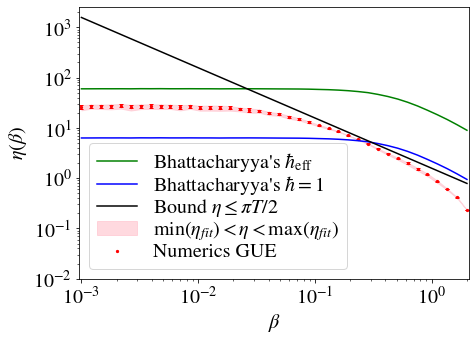

In [13]:
#T_arr=np.linspace(1/beta_arr[-1], 1/beta_arr[0], 100)
heff=2/(dim-1)
x=np.linspace(beta_arr[0], beta_arr[-1], 1000)
plt.figure(figsize=[7,5])
plt.fill_between(beta_arr, minlyap, maxlyap, color='pink', alpha=0.6, label=r"$\min(\eta_{fit})<\eta<\max(\eta_{fit})$")
#plt.scatter(beta_arr, maxlyap, color='r', label='Numerics GUE')
plt.scatter(beta_arr, lyap_beta, color='r', label='Numerics GUE', s=5)
plt.errorbar(beta_arr, lyap_beta, yerr=std_lyap, color='r', capsize=2, ls='None')
plt.plot(beta_arr, 2*dE/heff, color="green", label="Bhattacharyya's $\hbar_\mathrm{eff}$")
plt.plot(beta_arr, 2*dE, color="blue", label="Bhattacharyya's $\hbar=1$")
plt.plot(x, np.pi/(2*x), color='black', label=r"Bound $\eta \leq \pi T/2$")
#plt.plot(x, 2*np.pi/(x), color='black', label=r"Bound $\eta \leq 2 \pi T$")
plt.legend(labelspacing=0)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-2, )
#plt.xlim(1e-2, 2)
plt.xlim(beta_arr[0]*0.95,beta_arr[-1]*1.05)
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\eta(\beta)$")
plt.show()

In [14]:
"""dim_arr=[50, 20, 10, 5, 2]
plt.figure()
for j in dim_arr:
    aux=np.loadtxt("eta_beta_"+str(j)+".txt")
    plt.scatter(beta_arr, aux, label="$N=$"+str(j), s=15)
plt.yscale('log')
plt.xscale('log')
plt.legend(labelspacing=0, loc=[0.66, 0.5], handletextpad=0)
plt.plot(x, np.pi/(2*x), color='black')
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\eta(\beta)$")
plt.xlim(0.01, 1)
plt.ylim(0.3,)
plt.show()"""

'dim_arr=[50, 20, 10, 5, 2]\nplt.figure()\nfor j in dim_arr:\n    aux=np.loadtxt("eta_beta_"+str(j)+".txt")\n    plt.scatter(beta_arr, aux, label="$N=$"+str(j), s=15)\nplt.yscale(\'log\')\nplt.xscale(\'log\')\nplt.legend(labelspacing=0, loc=[0.66, 0.5], handletextpad=0)\nplt.plot(x, np.pi/(2*x), color=\'black\')\nplt.xlabel(r"$\x08eta$")\nplt.ylabel(r"$\\eta(\x08eta)$")\nplt.xlim(0.01, 1)\nplt.ylim(0.3,)\nplt.show()'

In [15]:
"""plt.figure()
plt.plot(t, total, label='Total', color='black')
plt.plot(t, term1, label='Term 1', color='orange')
plt.plot(t, term2, label='Term 2', ls='-.', color='red')
plt.plot(t, term3, label='Term 3', color='blue')
plt.xscale('log')
plt.grid()
plt.xlim(t[0], t[-1])
#plt.yscale('log')
#plt.ylim(1e-1, 1e3)
plt.xlabel("$t$")
plt.ylabel("$g(t)$")
plt.legend()
plt.show()"""

'plt.figure()\nplt.plot(t, total, label=\'Total\', color=\'black\')\nplt.plot(t, term1, label=\'Term 1\', color=\'orange\')\nplt.plot(t, term2, label=\'Term 2\', ls=\'-.\', color=\'red\')\nplt.plot(t, term3, label=\'Term 3\', color=\'blue\')\nplt.xscale(\'log\')\nplt.grid()\nplt.xlim(t[0], t[-1])\n#plt.yscale(\'log\')\n#plt.ylim(1e-1, 1e3)\nplt.xlabel("$t$")\nplt.ylabel("$g(t)$")\nplt.legend()\nplt.show()'

In [16]:
"""#print(avZ, avZGUE(β, dim))
aux1=np.ones(n_points_t)
plt.figure(figsize=[8, 6])
#cmap1=cm.get_cmap('viridis')
c_arr=['blue', 'green', 'orange', 'red']
for l in range(nbeta):
    l=nbeta-1-l
    fhat=np.real(F_Z[:,l]/F_Z[0, l])
    plt.scatter(t_arr, fhat,color=c_arr[l], label=r'$\beta=$'+str(beta_arr[l]))
    #plt.clim(np.log10(beta_arr[0]), np.log10(beta_arr[-1]))
    plt.plot(t, np.real(analyticF[:,l]/analyticF[0,l]), color=c_arr[l])
    #plt.axvspan(beta_arr[l]/(2*np.pi), beta_arr[l]/(2*np.pi)*np.log(dim), alpha=0.3, color=c_arr[l])
#plt.vlines(np.log(dim)/(2*np.pi/β), fhat[-1], 1, label='Minimum Ehrenfest Time', ls='-.')
#plt.vlines(1/(2*np.pi/β), fhat[-1], 1, label='Minimum Dissipation Time', ls='--')
plt.xlabel("t")
plt.ylabel("$F(t)/F(0)$")
plt.xscale('log')
plt.yscale('log')
plt.xlim(t_arr[1],)
#plt.ylim(np.min(fhat), 1)
plt.legend(labelspacing=0)
plt.show()"""

'#print(avZ, avZGUE(β, dim))\naux1=np.ones(n_points_t)\nplt.figure(figsize=[8, 6])\n#cmap1=cm.get_cmap(\'viridis\')\nc_arr=[\'blue\', \'green\', \'orange\', \'red\']\nfor l in range(nbeta):\n    l=nbeta-1-l\n    fhat=np.real(F_Z[:,l]/F_Z[0, l])\n    plt.scatter(t_arr, fhat,color=c_arr[l], label=r\'$\x08eta=$\'+str(beta_arr[l]))\n    #plt.clim(np.log10(beta_arr[0]), np.log10(beta_arr[-1]))\n    plt.plot(t, np.real(analyticF[:,l]/analyticF[0,l]), color=c_arr[l])\n    #plt.axvspan(beta_arr[l]/(2*np.pi), beta_arr[l]/(2*np.pi)*np.log(dim), alpha=0.3, color=c_arr[l])\n#plt.vlines(np.log(dim)/(2*np.pi/β), fhat[-1], 1, label=\'Minimum Ehrenfest Time\', ls=\'-.\')\n#plt.vlines(1/(2*np.pi/β), fhat[-1], 1, label=\'Minimum Dissipation Time\', ls=\'--\')\nplt.xlabel("t")\nplt.ylabel("$F(t)/F(0)$")\nplt.xscale(\'log\')\nplt.yscale(\'log\')\nplt.xlim(t_arr[1],)\n#plt.ylim(np.min(fhat), 1)\nplt.legend(labelspacing=0)\nplt.show()'